![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 3 - Optimization Methods </center>
### <center> Data Pre-processing and Weights Initialization</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/03_OptimizationMethods/MainInitialization.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})
np.random.seed(1)

###  What we have so far:
This part will grow so we will move this to its own module

In [3]:
class ReLULayer:
    def __init__(self):
        self.dParams = {}
        self.dGrads  = {}
    
    def Forward(self, mX):
        self.mX = mX                 #-- store for Backward
        mZ      = np.maximum(mX, 0)
        
        return mZ
    
    def Backward(self, mDz):
        mX    = self.mX
        mMask = (mX > 0).astype(np.float32)
        mDx   = mDz * mMask
                
        return mDx

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def CrossEntropyLoss(vY, mZ):
    '''
    Returns both the loss and the gradient w.r.t the input (mZ)
    '''
    N      = len(vY)
    mHatY  = np.exp(mZ)
    mHatY /= np.sum(mHatY, axis=0)
    loss   = -np.log(mHatY[vY,range(N)]).mean()
    
    mDz               = mHatY
    mDz[vY,range(N)] -= 1
    mDz              /= N
    
    return loss, mDz

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
class Model:
    def __init__(self, lLayers):
        self.lLayers = lLayers

    def Forward(self, mX):
        for oLayer in self.lLayers:
            mX = oLayer.Forward(mX)
        return mX

    def Backward(self, mDz):
        for oLayer in reversed(self.lLayers):
            mDz = oLayer.Backward(mDz)

#### Adding Kaiming (and Xavier) initialization to the linear layer:
$$\boldsymbol{W}\left[i,j\right]=\mathcal{N}\left(0,\sigma_w^2\right)$$
where:
* Xavier - $\sigma_{w}^{2}=\frac{1}{d}$
* Kaiming - $\sigma_{w}^{2}=\frac{2}{d}$
* $d$ is the input dimension.

In [4]:
class LinearLayer:
    def __init__(self, dIn, dOut, init='Kaiming'):
        if   init == 'Kaiming': mW = np.random.randn(dOut, dIn) * np.sqrt(2 / dIn)
        elif init == 'Xavier':  mW = np.random.randn(dOut, dIn) * np.sqrt(1 / dIn)
        else:                   mW = np.random.randn(dOut, dIn) / dIn #-- this is how we initialize previously
        
        vB = np.zeros(dOut)

        self.dParams = {'mW' : mW,   'vB': vB}
        self.dGrads  = {'mW' : None, 'vB' : None}

    def Forward(self, mX):
        mW      = self.dParams['mW']
        vB      = self.dParams['vB']
        self.mX = mX                   #-- store for Backward
        mZ      = mW @ mX + vB[:,None]

        return mZ

    def Backward(self, mDz):
        mW  = self.dParams['mW']
        mX  = self.mX
        
        vDb = mDz.sum(1)
        mDw = mDz  @ mX.T
        mDx = mW.T @ mDz
        
        self.dGrads['vB'] = vDb
        self.dGrads['mW'] = mDw

        return mDx


### Get Fashion MNIST dataset
We use the test set for validation.

In [5]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTrainSet = torchvision.datasets.FashionMNIST(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=transforms.ToTensor())

lClasses = oTrainSet.classes
mTrainX  = oTrainSet.data.view(-1,784).numpy() / 255
mTestX   = oTestSet .data.view(-1,784).numpy() / 255
vTrainY  = oTrainSet.targets.numpy()
vTestY   = oTestSet .targets.numpy()

(
mTrainX.shape, 
vTrainY.shape, 
mTestX .shape,  
vTestY .shape
)

((60000, 784), (60000,), (10000, 784), (10000,))

#### Classes:

In [6]:
list(zip(range(10), lClasses))

[(0, 'T-shirt/top'),
 (1, 'Trouser'),
 (2, 'Pullover'),
 (3, 'Dress'),
 (4, 'Coat'),
 (5, 'Sandal'),
 (6, 'Shirt'),
 (7, 'Sneaker'),
 (8, 'Bag'),
 (9, 'Ankle boot')]

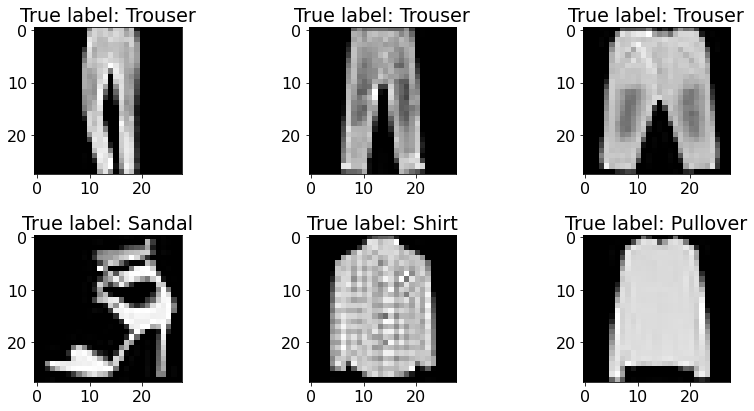

In [7]:
#-- Plot a few examples:
N, d   = mTrainX.shape
fig, _ = plt.subplots(2, 3, figsize=(12, 6))
for ax in fig.axes:
    idx = np.random.randint(N)
    ax.imshow   (np.reshape(mTrainX[idx,:], (28, 28)), cmap='gray')
    ax.set_title(f'True label: {lClasses[vTrainY[idx]]}')
    
plt.tight_layout()
plt.show()

### Define the training loop:
`mScore` is the network output (before the softmax), a.k.a <u>logits</u>.

In [8]:
import time

#-- Classification accuracy:
def Accuracy(mScore, vY):
    vHatY    = np.argmax(mScore, axis=0)
    accuracy = (vHatY == vY).mean()
    return accuracy
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def TrainEpoch(oModel, mX, vY, learningRate):
    #-- Forward:
    mZ        = oModel.Forward(mX)
    loss, mDz = CrossEntropyLoss(vY, mZ)

    #-- Backward:
    oModel.Backward(mDz)

    #-- Update parameters (vanilla gradient descnet)
    for oLayer in oModel.lLayers:
        for sParam in oLayer.dGrads:
            oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]
              
    #-- Check accuracy:
    acc = Accuracy(mZ, vY)
            
    return loss, acc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationEpoch(oModel, mX, vY):
    #-- Forward:
    mZ      = oModel.Forward(mX)
    loss, _ = CrossEntropyLoss(vY, mZ)
    acc     = Accuracy(mZ, vY)
    
    return loss, acc

In [9]:
def TrainModel(oModel, mTrainX, vTrainY, mValX, vValY, numEpochs, learningRate):
    lTrainLoss = []
    lValLoss   = []
    lTrainAcc  = []
    lValAcc    = []
    for epoch in range(numEpochs):
        startTime           = time.time()
        trainLoss, trainAcc = TrainEpoch     (oModel, mTrainX, vTrainY, learningRate) #-- train
        valLoss,   valAcc   = ValidationEpoch(oModel, mValX,   vValY)                 #-- validation
        endTime             = time.time()

        #-- Display:
        print('Epoch '              f'{epoch    :3d}:',  end='')
        print(' | Train loss: '     f'{trainLoss:6.3f}', end='')
        print(' | Val loss: '       f'{valLoss  :6.3f}', end='')
        print(' | Train Accuracy: ' f'{trainAcc :6.3f}', end='')
        print(' | Val Accuracy: '   f'{valAcc   :6.3f}', end='')
        print(' | epoch time: '     f'{(endTime-startTime):6.3f} |')
        
        lTrainLoss.append(trainLoss)
        lValLoss  .append(valLoss  )
        lTrainAcc .append(trainAcc )
        lValAcc   .append(valAcc   )
    
    return lTrainLoss, lValLoss, lTrainAcc, lValAcc

#### Train <u>without</u> normalizing and initialization:

In [10]:
oModel = Model([
        LinearLayer(784, 200, init=None), ReLULayer(),
        LinearLayer(200, 10,  init=None),
])

nEpochs = 30
lr      = 2e-1

_, lValLossV1, _, lValAccV1 = TrainModel(oModel, mTrainX.T, vTrainY, mTestX.T, vTestY, nEpochs, lr)

Epoch   0: | Train loss:  2.303 | Val loss:  2.301 | Train Accuracy:  0.091 | Val Accuracy:  0.361 | epoch time:  0.502 |
Epoch   1: | Train loss:  2.301 | Val loss:  2.300 | Train Accuracy:  0.365 | Val Accuracy:  0.466 | epoch time:  0.531 |
Epoch   2: | Train loss:  2.300 | Val loss:  2.298 | Train Accuracy:  0.473 | Val Accuracy:  0.464 | epoch time:  0.534 |
Epoch   3: | Train loss:  2.298 | Val loss:  2.295 | Train Accuracy:  0.472 | Val Accuracy:  0.449 | epoch time:  0.555 |
Epoch   4: | Train loss:  2.295 | Val loss:  2.292 | Train Accuracy:  0.456 | Val Accuracy:  0.414 | epoch time:  0.519 |
Epoch   5: | Train loss:  2.292 | Val loss:  2.287 | Train Accuracy:  0.421 | Val Accuracy:  0.365 | epoch time:  0.508 |
Epoch   6: | Train loss:  2.287 | Val loss:  2.281 | Train Accuracy:  0.371 | Val Accuracy:  0.294 | epoch time:  0.526 |
Epoch   7: | Train loss:  2.281 | Val loss:  2.272 | Train Accuracy:  0.303 | Val Accuracy:  0.237 | epoch time:  0.489 |
Epoch   8: | Train loss:

####  Normalize data:
Based on the training data

In [11]:
vMean = mTrainX.mean(0)
vStd  = mTrainX.std (0)

mTrainX -= vMean
mTestX  -= vMean
mTrainX /= vStd
mTestX  /= vStd

#### Train <u>with</u> normalizing and initialization:

In [12]:
oModel = Model([
        LinearLayer(784, 200, init='Kaiming'),
        ReLULayer(),
        LinearLayer(200, 10,  init='Xavier'),   
])

nEpochs = 30
lr      = 2e-1

_, lValLossV2, _, lValAccV2 = TrainModel(oModel, mTrainX.T, vTrainY, mTestX.T, vTestY, nEpochs, lr)

Epoch   0: | Train loss:  2.668 | Val loss:  1.285 | Train Accuracy:  0.063 | Val Accuracy:  0.575 | epoch time:  0.557 |
Epoch   1: | Train loss:  1.273 | Val loss:  1.049 | Train Accuracy:  0.575 | Val Accuracy:  0.653 | epoch time:  0.561 |
Epoch   2: | Train loss:  1.035 | Val loss:  0.947 | Train Accuracy:  0.659 | Val Accuracy:  0.672 | epoch time:  0.559 |
Epoch   3: | Train loss:  0.931 | Val loss:  0.915 | Train Accuracy:  0.681 | Val Accuracy:  0.682 | epoch time:  0.522 |
Epoch   4: | Train loss:  0.901 | Val loss:  0.944 | Train Accuracy:  0.688 | Val Accuracy:  0.654 | epoch time:  0.529 |
Epoch   5: | Train loss:  0.924 | Val loss:  1.048 | Train Accuracy:  0.660 | Val Accuracy:  0.653 | epoch time:  0.533 |
Epoch   6: | Train loss:  1.037 | Val loss:  0.895 | Train Accuracy:  0.661 | Val Accuracy:  0.685 | epoch time:  0.595 |
Epoch   7: | Train loss:  0.871 | Val loss:  0.822 | Train Accuracy:  0.691 | Val Accuracy:  0.716 | epoch time:  0.604 |
Epoch   8: | Train loss:

### Compare the two configurations:

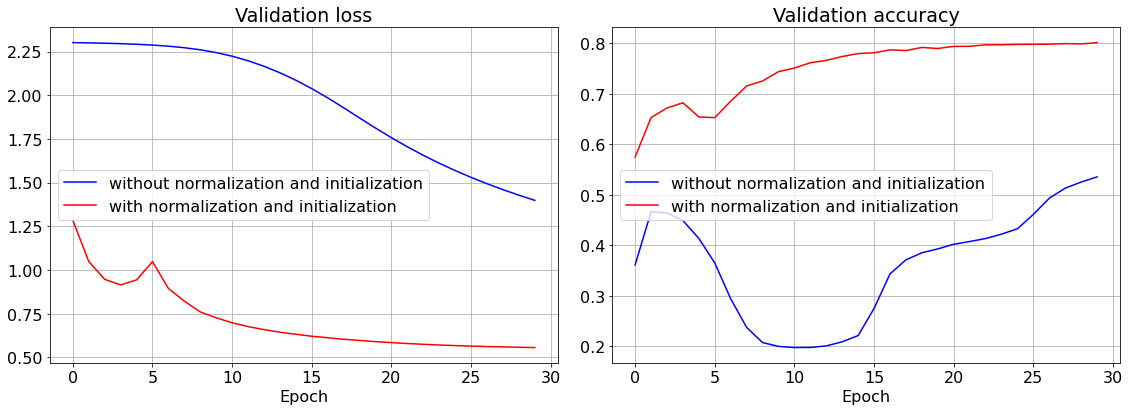

In [13]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot   (lValLossV1, 'b', label='without normalization and initialization')
plt.plot   (lValLossV2, 'r', label='with normalization and initialization')
plt.title  ('Validation loss')
plt.xlabel ('Epoch')
plt.grid   ()
plt.legend ()

plt.subplot(1,2,2)
plt.plot   (lValAccV1, 'b', label='without normalization and initialization')
plt.plot   (lValAccV2, 'r', label='with normalization and initialization')
plt.title  ('Validation accuracy')
plt.xlabel ('Epoch')
plt.grid   ()
plt.legend ()

plt.tight_layout()
plt.show()

### Exercise
Implement the `CountParameters` function
* Input: A model.
* Output: The number of parameters in the model.

In [14]:
def CountParameters(oModel):
    ???

    return nParams

In [15]:
oModel = Model([
        LinearLayer(784, 200, init=None), ReLULayer(),
        LinearLayer(200, 150, init=None), ReLULayer(),
        LinearLayer(150, 10,  init=None),
])

CountParameters(oModel)

Object `?` not found.


NameError: name 'nParams' is not defined

In [ ]:
# def CountParameters(oModel):
#     nParams = 0
#     for oLayer in oModel.lLayers:
#         for key in oLayer.dParams:
#             nParams += oLayer.dParams[key].size()

#     return nParams